We load a pre-trained DINO model without any additional training to generate embeddings for images.

In [1]:
# === Imports ===
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# === Load DINOv2 Model ===
dinov2_vitb14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vitb14")
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
dinov2_vitb14.to(device)


Mounted at /content/drive


Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth
100%|██████████| 330M/330M [00:04<00:00, 74.0MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affi

We then apply various image transformations and extract embeddings for each transformation.


In [2]:
# === Image Transformations ===
class PadToCenter224:
    def __call__(self, img):
        w, h = img.size
        scale = min(224 / w, 224 / h, 1.0)
        new_w, new_h = int(w * scale), int(h * scale)
        img = img.resize((new_w, new_h), Image.BICUBIC)
        canvas = Image.new("RGB", (224, 224), (0, 0, 0))
        left = (224 - new_w) // 2
        top = (224 - new_h) // 2
        canvas.paste(img, (left, top))
        return canvas

def resize_and_pad(size):
    class ResizeAndPad:
        def __call__(self, img):
            img = img.resize((size, size), Image.BICUBIC)
            canvas = Image.new("RGB", (224, 224), (0, 0, 0))
            left = (224 - size) // 2
            top = (224 - size) // 2
            canvas.paste(img, (left, top))
            return canvas
    return ResizeAndPad()

class Duplicate2x2Grid:
    def __call__(self, img):
        w, h = img.size
        grid_img = Image.new("RGB", (w * 2, h * 2))
        for i in range(2):
            for j in range(2):
                grid_img.paste(img, (i * w, j * h))
        grid_img = grid_img.resize((224, 224), Image.BICUBIC)
        return grid_img

normalize = T.Compose([T.ToTensor(), T.Normalize([0.5]*3, [0.5]*3)])

transforms_dict = {
    "pad_center_224": T.Compose([PadToCenter224(), normalize]),
    "resize_224": T.Compose([T.Resize((224, 224)), normalize]),
    "resize_100_pad": T.Compose([resize_and_pad(100), normalize]),
    "resize_150_pad": T.Compose([resize_and_pad(150), normalize]),
    "resize_200_pad": T.Compose([resize_and_pad(200), normalize]),
    "resize_50_pad": T.Compose([resize_and_pad(50), normalize]),
    "grid_2x2": T.Compose([Duplicate2x2Grid(), normalize]),
}


In [3]:
# === Utility Functions ===
def get_image_paths(directory):
    image_paths = []
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            for img in os.listdir(class_path):
                if img.endswith(('.jpg', '.png', '.jpeg')):
                    image_paths.append(os.path.join(class_path, img))
    return image_paths

def extract_embeddings_with_transform(image_paths, transform):
    embeddings = []
    labels = []
    with torch.no_grad():
        for path in tqdm(image_paths):
            img = Image.open(path).convert("RGB")
            tensor_img = transform(img).unsqueeze(0).to(device)
            emb = dinov2_vitb14(tensor_img)
            embeddings.append(emb[0].cpu().numpy().reshape(-1))
            labels.append(os.path.basename(os.path.dirname(path)))
    return np.array(embeddings), np.array(labels)

def compute_class_separation(X, y):
    classes = np.unique(y)
    centroids = [np.mean(X[y == cls], axis=0) for cls in classes]
    dists = []
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            d = np.linalg.norm(centroids[i] - centroids[j])
            dists.append(d)
    return np.mean(dists)

# === Paths ===
base_dir = "/content/drive/MyDrive/triangle_truncated_circle_small"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "validation")

train_images = get_image_paths(train_dir)
test_images = get_image_paths(test_dir)
val_images = get_image_paths(val_dir)

Next, we evaluate these embeddings using the Separation score and select the transformation that yields the highest score.



Processing: pad_center_224


  0%|          | 0/18 [00:00<?, ?it/s]


Processing: resize_224


  0%|          | 0/18 [00:00<?, ?it/s]


Processing: resize_100_pad


  0%|          | 0/18 [00:00<?, ?it/s]


Processing: resize_150_pad


  0%|          | 0/18 [00:00<?, ?it/s]


Processing: resize_200_pad


  0%|          | 0/18 [00:00<?, ?it/s]


Processing: resize_50_pad


  0%|          | 0/18 [00:00<?, ?it/s]


Processing: grid_2x2


  0%|          | 0/18 [00:00<?, ?it/s]

/tmp/ipython-input-4-2170555416.py:50: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


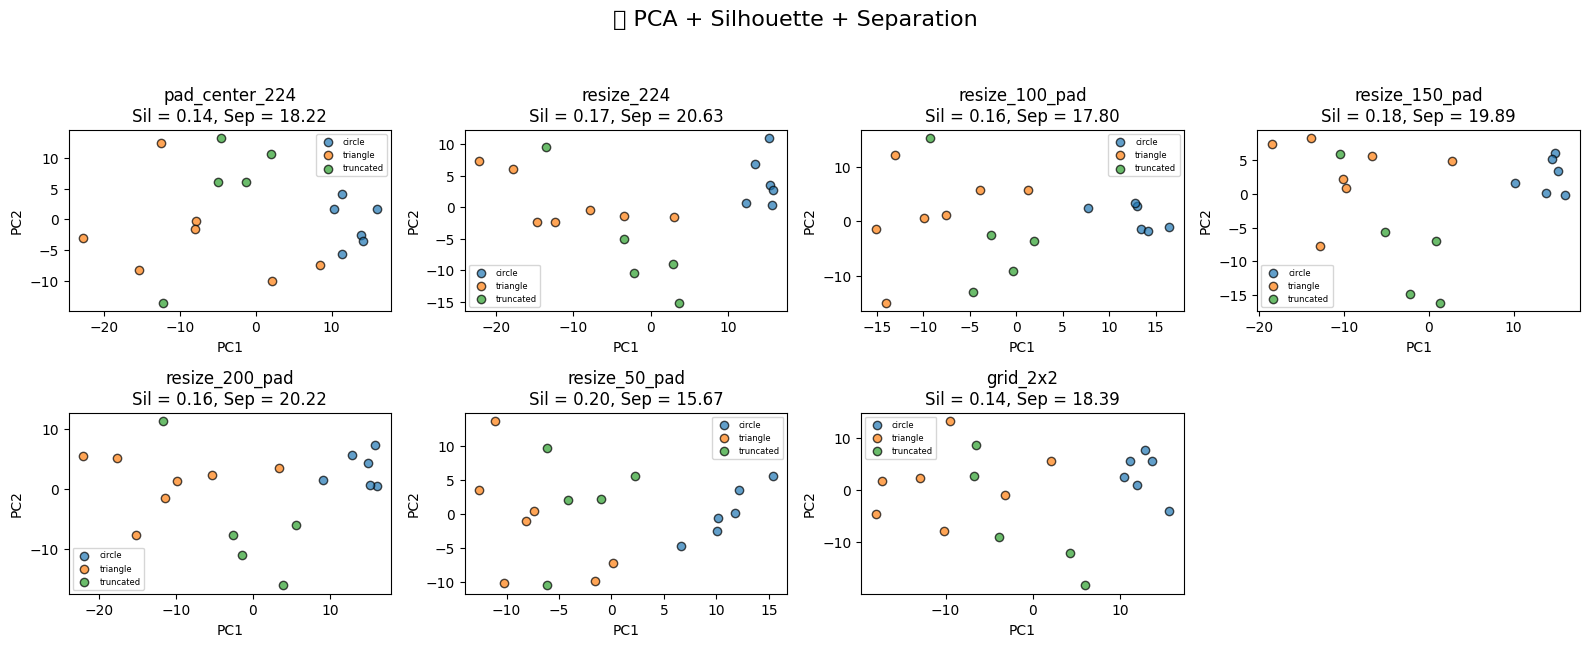


Summary Table:
Transformation  Silhouette Score  Separation Score
 resize_50_pad             0.196            15.669
resize_150_pad             0.184            19.887
    resize_224             0.170            20.634
resize_200_pad             0.164            20.222
resize_100_pad             0.157            17.805
pad_center_224             0.139            18.220
      grid_2x2             0.138            18.390


In [4]:
# === Score dictionaries + Embeddings storage ===
silhouette_scores = {}
separation_scores = {}
all_embeddings = {}  # 💾 To store all embeddings

# === Visualization ===
n_plots = len(transforms_dict)
rows = 3
cols = 4
plt.figure(figsize=(cols * 4, rows * 3))

for i, (name, transform) in enumerate(transforms_dict.items(), 1):
    print(f"\nProcessing: {name}")

    # Step 1: Extract embeddings
    X, y = extract_embeddings_with_transform(train_images, transform)

    # Save embedding
    all_embeddings[name] = {"X": X, "y": y}

    # Step 2: Compute metrics
    sil_score = silhouette_score(X, y)
    sep_score = compute_class_separation(X, y)

    silhouette_scores[name] = sil_score
    separation_scores[name] = sep_score

    # Step 3: PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    classes = np.unique(y)
    class_to_color = {cls: plt.cm.tab10(i % 10) for i, cls in enumerate(classes)}

    plt.subplot(rows, cols, i)
    for cls in classes:
        idx = y == cls
        plt.scatter(
            X_pca[idx, 0], X_pca[idx, 1],
            label=cls,
            color=class_to_color[cls],
            alpha=0.7, edgecolors='k'
        )
    plt.title(f"{name}\nSil = {sil_score:.2f}, Sep = {sep_score:.2f}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(fontsize=6)


plt.suptitle("📊 PCA + Silhouette + Separation", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# === Summary Table ===
summary_df = pd.DataFrame({
    "Transformation": list(silhouette_scores.keys()),
    "Silhouette Score": list(silhouette_scores.values()),
    "Separation Score": list(separation_scores.values())
})

summary_df = summary_df.sort_values(by="Silhouette Score", ascending=False)

print("\nSummary Table:")
print(summary_df.to_string(index=False, float_format="%.3f"))

Using the best transformation, we generate embeddings for the training, validation, and test sets, and save these embeddings for further use.

In [5]:
# === Step 4: Select best transform by separation score ===
best_transform_name = max(separation_scores, key=separation_scores.get)
best_transform = transforms_dict[best_transform_name]
print(f"\n✅ Best transform selected: {best_transform_name}")

X_train = all_embeddings[best_transform_name]["X"]
y_train = all_embeddings[best_transform_name]["y"]


✅ Best transform selected: resize_224


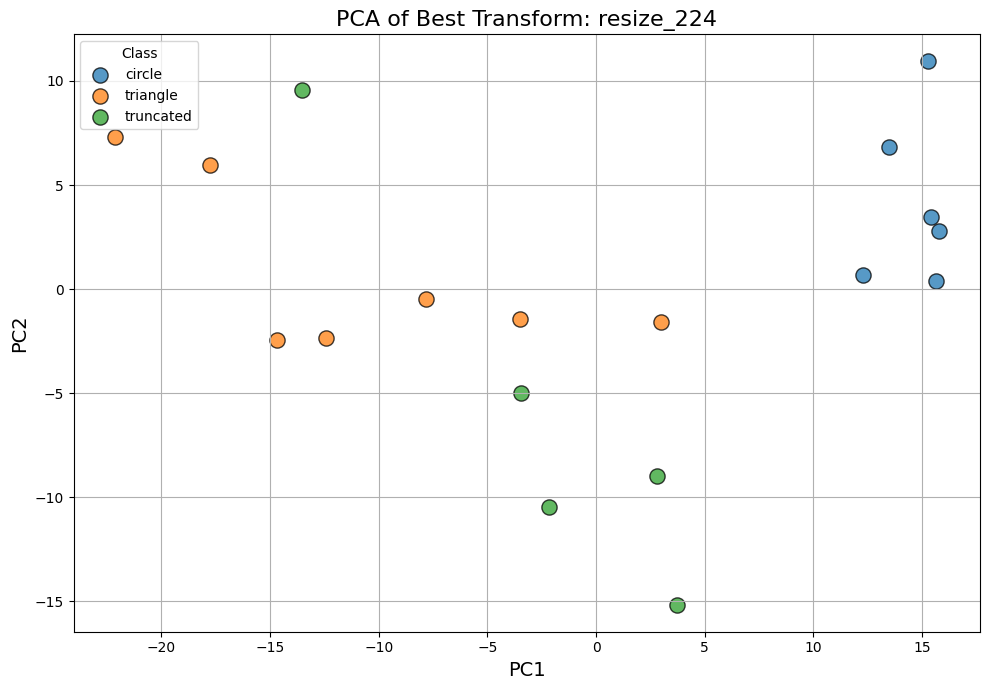

In [6]:
# === Step 5: PCA of best transform ===
le = LabelEncoder()
y_encoded = le.fit_transform(y_train)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

colors = plt.cm.tab10.colors
num_classes = len(np.unique(y_encoded))

plt.figure(figsize=(10, 7))
for class_index in range(num_classes):
    idx = y_encoded == class_index
    plt.scatter(
        X_pca[idx, 0],
        X_pca[idx, 1],
        s=120,
        color=colors[class_index % len(colors)],
        label=le.inverse_transform([class_index])[0],
        alpha=0.75,
        edgecolors='k'
    )

plt.title(f"PCA of Best Transform: {best_transform_name}", fontsize=16)
plt.xlabel("PC1", fontsize=14)
plt.ylabel("PC2", fontsize=14)
plt.legend(title="Class", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
# === Step 6: Create test and val embeddings using best transform ===
print("\nExtracting test embeddings...")
X_test, y_test = extract_embeddings_with_transform(test_images, best_transform)

print("\nExtracting validation embeddings...")
X_val, y_val = extract_embeddings_with_transform(val_images, best_transform)



Extracting test embeddings...


  0%|          | 0/105 [00:00<?, ?it/s]


Extracting validation embeddings...


  0%|          | 0/19 [00:00<?, ?it/s]

In [8]:
save_path = '/content/drive/MyDrive/my_embeddings_folder_triangles/'

import os
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save best transform name
with open(os.path.join(save_path, "best_transform_name.txt"), "w") as f:
    f.write(best_transform_name)

# Save embeddings and labels
np.save(os.path.join(save_path, 'best_train_embeddings.npy'), X_train)
np.save(os.path.join(save_path, 'train_labels.npy'), y_train)
np.save(os.path.join(save_path, 'test_embeddings.npy'), X_test)
np.save(os.path.join(save_path, 'test_labels.npy'), y_test)
np.save(os.path.join(save_path, 'val_embeddings.npy'), X_val)
np.save(os.path.join(save_path, 'val_labels.npy'), y_val)

print("✅ All embeddings saved successfully to Google Drive.")


✅ All embeddings saved successfully to Google Drive.
